In [1]:
import xupy as xp
import matplotlib.pyplot as plt
from numpy.ma import masked_array

from ekarus.e2e.utils.image_utils import reshape_on_mask, image_grid

from ekarus.e2e.single_stage_ao_class import SingleStageAO


[XuPy] Device 0 available - GPU : `NVIDIA GeForce RTX 4060 Laptop GPU`
       Memory = 7805.56 MB | Compute Capability = 8.9
       Using CuPy 13.5.1 for acceleration.


In [2]:
def define_target_roi(pupil, iwa, owa, oversampling:int, symmetric:bool=False, heightInLambdaOverD=None):
    mask_shape = max(pupil.shape)
    padded_pupil = xp.pad(1-pupil.copy(), pad_width=int((mask_shape*(oversampling-1)//2)), mode='constant', constant_values=0.0)
    X,Y = image_grid(padded_pupil.shape,recenter=True)
    rho = xp.sqrt(X**2+Y**2)
    if symmetric is True:
        where = (rho <= owa*oversampling) * (rho >= iwa*oversampling)
    else:
        where = (rho <= owa*oversampling) * (X >= iwa*oversampling) 
    if heightInLambdaOverD is not None:
        where *= (abs(Y) < heightInLambdaOverD/2*oversampling)
    return where

def define_apodizing_phase(pupil, res_phi_in_rad, roi, R, IF,
                           oversampling:int, max_its:int=200,
                           initial_guess=None, gains=0.1,
                           change_gain_its:list=None, beta:float=0.0,
                           show_step:int=None):
    if change_gain_its is not None:
        assert len(change_gain_its) == len(gains)-1
        gain_ctr = 0
        gain = gains[gain_ctr]
        change_gain_it = change_gain_its[gain_ctr]
    else:
        gain = gains
        change_gain_it = None

    mask_shape = max(pupil.shape)
    pad_width = int((mask_shape*(oversampling-1)//2))
    padded_pupil = xp.pad(1-pupil, pad_width=pad_width, mode='constant', constant_values=0.0)

    phi = reshape_on_mask(res_phi_in_rad, (pupil).astype(bool))
    field = (1-pupil) * xp.exp(1j*phi,dtype=xp.complex64)
    pad_field = xp.pad(field, pad_width=pad_width, mode='constant', constant_values=0.0)
    focal_field = xp.fft.fftshift(xp.fft.fft2(pad_field))
    ref_psf = xp.abs(focal_field)**2

    dm_phase = initial_guess if initial_guess is not None else xp.zeros_like(res_phi_in_rad)
    roi_contrast = xp.zeros([3,max_its])
    best_contrast = 0
    best_phase = dm_phase.copy()

    for j in range(max_its):
        phi = reshape_on_mask(res_phi_in_rad+dm_phase, (pupil).astype(bool))
        field = (1-pupil) * xp.exp(1j*phi,dtype=xp.complex64)
        pad_field = xp.pad(field, pad_width=pad_width, mode='constant', constant_values=0.0)
        focal_field = xp.fft.fftshift(xp.fft.fft2(pad_field))
        ff_roi = focal_field * roi
        pup_field_roi = xp.fft.ifft2(xp.fft.ifftshift(ff_roi))
        phase = xp.angle(pup_field_roi)[padded_pupil>0.0]
        cmd = R @ phase
        rec_phi = IF @ cmd

        contrast = xp.log10(xp.abs(focal_field)**2/xp.max(ref_psf))
        roi_contrast[0,j] = xp.max(contrast[roi])
        roi_contrast[1,j] = xp.mean(contrast[roi]) 
        roi_contrast[2,j] = xp.min(contrast[roi])

        if change_gain_it == j and change_gain_it is not None:
            gain_ctr += 1
            gain = gains[gain_ctr]
            if gain_ctr < len(change_gain_its):
                change_gain_it = change_gain_its[gain_ctr]
            else:
                change_gain_it = None

        if xp.mean(contrast[roi]) < best_contrast:
            best_contrast = xp.mean(contrast[roi]) 
            best_phase = dm_phase.copy()

        if show_step is not None:
            if j % show_step == 0:
                plt.figure(figsize=(20,4))        
                plt.subplot(1,4,1)
                plt.imshow(masked_array(xp.asnumpy(phi),mask=xp.asnumpy(pupil)),origin='lower',cmap='RdBu')
                plt.colorbar()
                plt.title('Field + DM phase')
                plt.subplot(1,4,4)
                plt.imshow(masked_array(xp.asnumpy(reshape_on_mask(rec_phi,(pupil).astype(bool))),mask=xp.asnumpy(pupil)),origin='lower',cmap='RdBu')
                plt.colorbar()
                plt.title('Reconstructed DM phase')
                plt.subplot(1,4,3)
                plt.imshow(masked_array(xp.asnumpy(contrast),mask=xp.asnumpy(1-roi)),
                        origin='lower',cmap='twilight',vmin=-12,vmax=0)
                cbar=plt.colorbar()
                cbar.ax.set_title('Contrast')
                plt.xlim([mask_shape*oversampling//2-mask_shape//2,mask_shape*oversampling//2+mask_shape//2])
                plt.ylim([mask_shape*oversampling//2-mask_shape//2,mask_shape*oversampling//2+mask_shape//2])
                plt.title(f'ROI average contrast: {xp.mean(contrast[roi]):1.1f}')
                plt.subplot(1,4,2)
                plt.imshow(xp.asnumpy(contrast),origin='lower',cmap='twilight',vmin=-12,vmax=0)
                cbar=plt.colorbar()
                cbar.ax.set_title('Contrast')
                plt.xlim([mask_shape*oversampling//2-mask_shape//2,mask_shape*oversampling//2+mask_shape//2])
                plt.ylim([mask_shape*oversampling//2-mask_shape//2,mask_shape*oversampling//2+mask_shape//2])
                plt.title(f'PSF\nIteration {j:1.0f}')
        # dm_phase -= gain * rec_phi
        # dm_phase = beta * dm_phase - rec_phi * (1 + beta)
        dm_phase += gain * (beta * dm_phase - rec_phi * (1 + beta))

    return best_phase, roi_contrast

In [3]:
def calc_psf(ef, oversampling:int=8):
    pad_width = int((max(ef.shape)*(oversampling-1)//2))
    pad_ef = xp.pad(ef, pad_width=pad_width, mode='constant', constant_values=0.0)
    ff = xp.fft.fftshift(xp.fft.fft2(pad_ef))
    return xp.real(ff * xp.conj(ff))

def show_psf(psf, norm=None, oversampling:int=8, title:str='', ext=0.3, vmin=-10):
    pixelSize = 1/oversampling
    imageHalfSizeInPoints= psf.shape[0]/2
    roi= [int(imageHalfSizeInPoints*(1-ext)), int(imageHalfSizeInPoints*(1+ext))]
    psfZoom = psf[roi[0]: roi[1], roi[0]:roi[1]]
    sz = psfZoom.shape
    if norm is None:
        norm = xp.max(psf)
    plt.imshow(xp.asnumpy(xp.log10(psfZoom/norm)), extent=
               [-sz[0]/2*pixelSize, sz[0]/2*pixelSize,
               -sz[1]/2*pixelSize, sz[1]/2*pixelSize],
               origin='lower',cmap='inferno',vmin=vmin,vmax=0)
    plt.xlabel(r'$\lambda/D$')
    plt.ylabel(r'$\lambda/D$')
    cbar= plt.colorbar()
    cbar.ax.set_title('Contrast')
    plt.title(title)

In [4]:
ssao = SingleStageAO('offaxis_8m')
atmo_phases,res_phases = ssao.load_telemetry_data(data_keys=['mag7_atmo_phases','mag7_residual_phases'])
m2rad = 2*xp.pi/ssao.pyr.lambdaInM

Initializing devices ...
Modulating 3 [lambda/D] with 20 modulation steps


In [ ]:
def define_bright_field(psf, min_contrast, dm_owa, oversampling):
    X,Y = image_grid(psf.shape,recenter=True)
    rho = xp.sqrt(X**2+Y**2)
    where = xp.asarray(xp.log10(psf/xp.max(psf)) > min_contrast,dtype=bool)
    where *= (rho < dm_owa*oversampling) 
    return where

def calibrate_int_mat(dh_phi_in_rad, pupil, cmdmat, IF, n_acts:int, 
                      oversampling:int, show:bool=False, bf_thr:float=-4.5, amp:float=20e-9):
    
    dh_phi_2d = reshape_on_mask(dh_phi_in_rad,pupil)
    ef = (1-pupil) * xp.exp(1j*dh_phi_2d,dtype=xp.complex64)
    psf = calc_psf(ef, oversampling=oversampling)
    
    bf = define_bright_field(psf, min_contrast=bf_thr, 
                             oversampling=oversampling, dm_owa=n_acts/2)
    ref_bright_pix = psf[bf]

    # plt.figure()
    # show_psf(psf*bf,ext=0.4,title='Bright field')
    
    Nmodes = xp.shape(cmdmat)[0]
    IntMat = xp.zeros([Nmodes-1,int(xp.sum(bf))])

    for j in range(Nmodes-1):
        cmd = cmdmat[j,:] * amp
        mode = IF @ cmd

        phase = reshape_on_mask(mode*m2rad,pupil)
        ef = (1-pupil) * xp.exp(1j*(dh_phi_2d+phase),dtype=xp.complex64)
        psf = calc_psf(ef, oversampling=oversampling)
        push = psf[bf]
        nef = (1-pupil) * xp.exp(1j*(dh_phi_2d-phase),dtype=xp.complex64)
        npsf = calc_psf(nef, oversampling=oversampling)
        pull = npsf[bf]

        IntMat[j,:] = xp.asarray((push-pull)/(2*amp))

    if show:
        U,_,_ = xp.linalg.svd(IntMat,full_matrices=False)
        def get_mode(id):
            cmd = xp.asarray(cmdmat) @ U[:,id].T
            return IF @ cmd

        plt.figure(figsize=(22,14))
        for j in range(10):
            plt.subplot(4,5,j+1)
            ssao.dm.plot_surface(get_mode(j))
            plt.title(f'Mode {j:1.0f}')
        for j in range(10):
            plt.subplot(4,5,20-j)
            ssao.dm.plot_surface(get_mode(Nmodes-1-j))
            plt.title(f'Mode {Nmodes-j:1.0f}')
    
    return IntMat, bf, ref_bright_pix
    

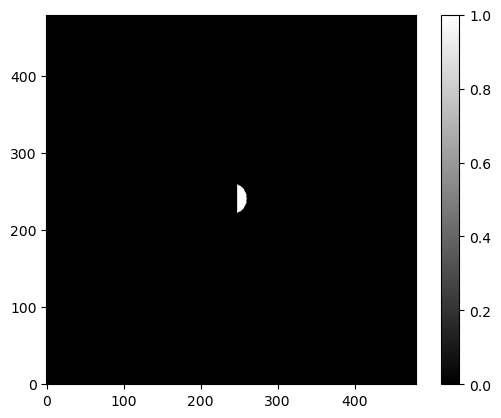

In [6]:
iwaInLambdaOverD = 2 #3.5
owaInLambdaOverD = 5 #7.5
heightInLambdaOverD = None
oversampling = 4
pupil = ssao.cmask.copy()

roi = define_target_roi(pupil, iwaInLambdaOverD, owaInLambdaOverD, oversampling, heightInLambdaOverD=heightInLambdaOverD)
plt.figure()
plt.imshow(xp.asnumpy(roi),origin='lower',cmap='gray')
plt.colorbar()

In [7]:
id = 100
phi = xp.asarray(res_phases[id].data)*m2rad
res_phi_in_rad = phi[~pupil]

IF = ssao.dm.IFF.T
R = xp.linalg.pinv(IF)
dm_phi_in_rad, roi_contrast = define_apodizing_phase(pupil, 
                                  res_phi_in_rad, roi, IF, R, 
                                  oversampling=oversampling, max_its=2000, beta=0.1,
                                  gains=[0.02,0.001], change_gain_its = [100])#, show_step=30)

dh_phi_in_rad = dm_phi_in_rad + res_phi_in_rad

Text(0.5, 1.0, 'Contrast in dark zone')

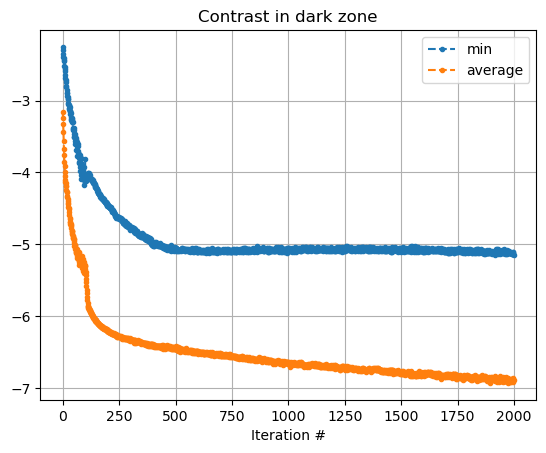

In [8]:
plt.figure()
plt.plot(xp.asnumpy(roi_contrast[0]),'--.',label='min')
plt.plot(xp.asnumpy(roi_contrast[1]),'--.',label='average')
# plt.plot(xp.asnumpy(roi_contrast[2]),'--.',label='max')
plt.legend()
plt.grid()
plt.xlabel('Iteration #')
plt.title('Contrast in dark zone')

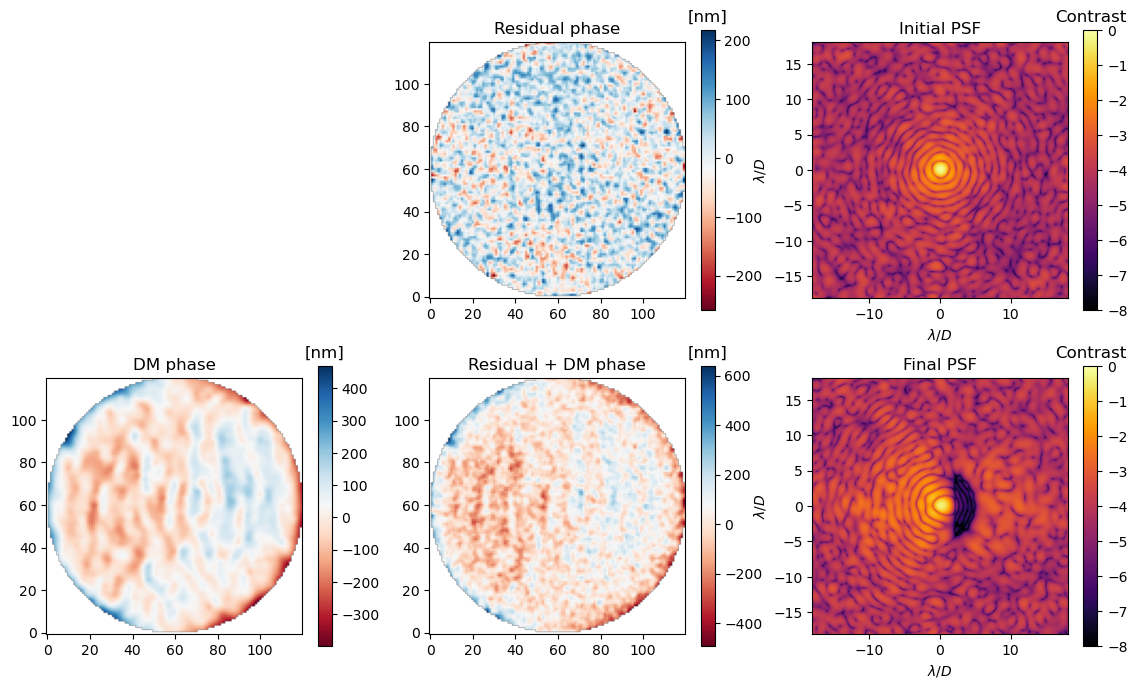

In [9]:
res_phi_2d = reshape_on_mask(res_phi_in_rad,pupil)
dm_phi_2d = reshape_on_mask(dm_phi_in_rad,pupil)

psf_oversampling = 12

dl_ef = (1-pupil) * xp.exp(1j*res_phi_2d*0,dtype=xp.complex64)
res_ef = (1-pupil) * xp.exp(1j*res_phi_2d,dtype=xp.complex64)
ef = (1-pupil) * xp.exp(1j*(res_phi_2d+dm_phi_2d),dtype=xp.complex64)

dl_psf = calc_psf(dl_ef, oversampling=psf_oversampling)
res_psf = calc_psf(res_ef, oversampling=psf_oversampling)
psf = calc_psf(ef, oversampling=psf_oversampling)

plt.figure(figsize=(14,8))
plt.subplot(2,3,2)
plt.imshow(masked_array(xp.asnumpy(res_phi_2d/m2rad*1e+9),mask=xp.asnumpy(pupil)),origin='lower',cmap='RdBu')
cbar=plt.colorbar()
cbar.ax.set_title('[nm]')
plt.title('Residual phase')
plt.subplot(2,3,4)
plt.imshow(masked_array(xp.asnumpy(dm_phi_2d/m2rad*1e+9),mask=xp.asnumpy(pupil)),origin='lower',cmap='RdBu')
cbar=plt.colorbar()
cbar.ax.set_title('[nm]')
plt.title('DM phase')
plt.subplot(2,3,5)
plt.imshow(masked_array(xp.asnumpy((dm_phi_2d+res_phi_2d)/m2rad*1e+9),mask=xp.asnumpy(pupil)),origin='lower',cmap='RdBu')
cbar=plt.colorbar()
cbar.ax.set_title('[nm]')
plt.title('Residual + DM phase')
plt.subplot(2,3,6)
show_psf(psf, norm=xp.max(dl_psf), oversampling=psf_oversampling, title='Final PSF', vmin=-8)
plt.subplot(2,3,3)
show_psf(res_psf, norm=xp.max(dl_psf), oversampling=psf_oversampling, title='Initial PSF', vmin=-8)

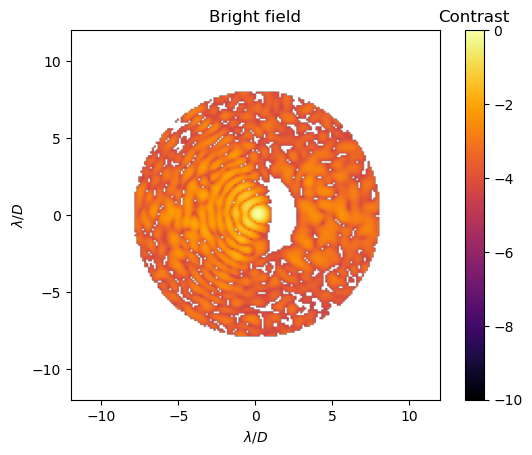

In [10]:
psf = calc_psf(ef, oversampling=oversampling)
bf = define_bright_field(psf, min_contrast=-4.5, oversampling=oversampling, dm_owa=32/2)
ref_bright_pix = psf[bf]

plt.figure()
show_psf(psf*bf,ext=0.4,title='Bright field')

In [11]:
from scipy.linalg import hadamard

Nmodes = ssao.dm.Nacts
hadamat = hadamard(2048)
hadamat = hadamat[1:Nmodes+1,:]
hadamat = hadamat[:,1:Nmodes+1]
hadamat = xp.asarray(hadamat)

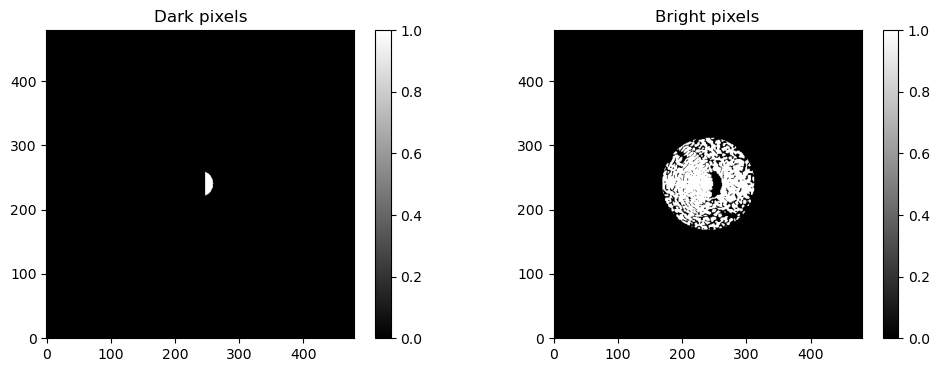

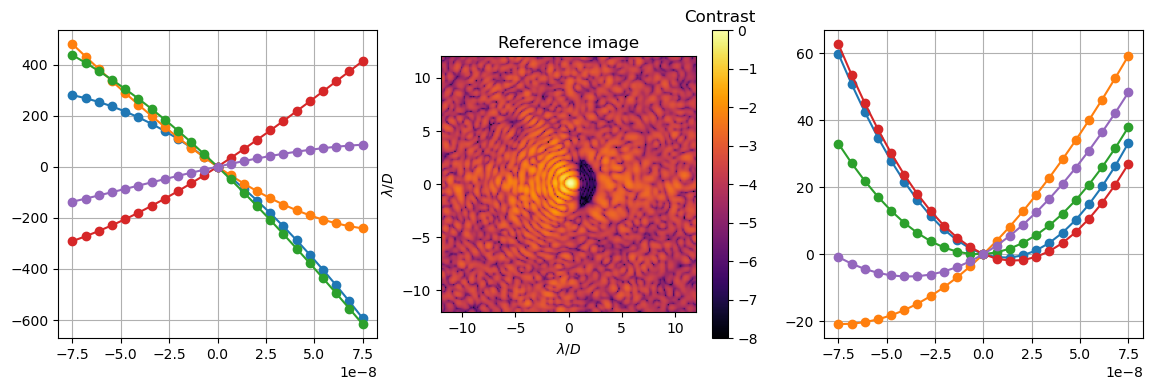

In [12]:
amp_vec =xp.linspace(-1,1,23)*75e-9

dh_phi_2d = reshape_on_mask(dh_phi_in_rad,pupil)
ef = (1-pupil) * xp.exp(1j*dh_phi_2d,dtype=xp.complex64)
ref_psf = calc_psf(ef, oversampling=oversampling)

bf = define_bright_field(ref_psf, min_contrast=-4, oversampling=oversampling, dm_owa=36/2)

ids = xp.arange(xp.size(psf)).reshape(psf.shape)
bright_ids = ids[bf]
dark_ids = ids[roi]
# print(len(bright_ids),xp.sum(bf),len(dark_ids),xp.sum(roi))

dark_roi = xp.zeros(xp.size(psf))
dark_roi[dark_ids] = 1
dark_roi = xp.reshape(dark_roi,psf.shape)

bright_roi = xp.zeros(xp.size(psf))
bright_roi[bright_ids] = 1
bright_roi = xp.reshape(bright_roi,psf.shape)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.imshow(xp.asnumpy(dark_roi),origin='lower',cmap='gray')
plt.colorbar()
plt.title('Dark pixels')
plt.subplot(1,2,2)
plt.imshow(xp.asnumpy(bright_roi),origin='lower',cmap='gray')
plt.colorbar()
plt.title('Bright pixels')


N = 5
bright_amp = xp.zeros([N,len(amp_vec)])
dark_amp = xp.zeros([N,len(amp_vec)])

for k,amp in enumerate(amp_vec):
    # cmd = hadamat[12,:] * amp
    cmd = xp.zeros(ssao.dm.Nacts)
    cmd[16] = amp
    mode = IF.T @ cmd

    phase = reshape_on_mask(mode*m2rad,pupil)
    ef = (1-pupil) * xp.exp(1j*(dh_phi_2d+phase),dtype=xp.complex64)
    psf = calc_psf(ef, oversampling=oversampling)
    
    for j in range(N):
        bright_amp[j,k] = (psf-ref_psf).flatten()[int(bright_ids[100+j*4])]
        dark_amp[j,k] = (psf-ref_psf).flatten()[int(dark_ids[100+j*4])]

plt.figure(figsize=(14,4))
plt.subplot(1,3,2)
show_psf(ref_psf,ext=0.4,title='Reference image',vmin=-8)
plt.subplot(1,3,1)
plt.plot(xp.asnumpy(amp_vec),xp.asnumpy(bright_amp.T),'-o')
plt.grid()
plt.subplot(1,3,3)
plt.plot(xp.asnumpy(amp_vec),xp.asnumpy(dark_amp.T),'-o')
plt.grid()

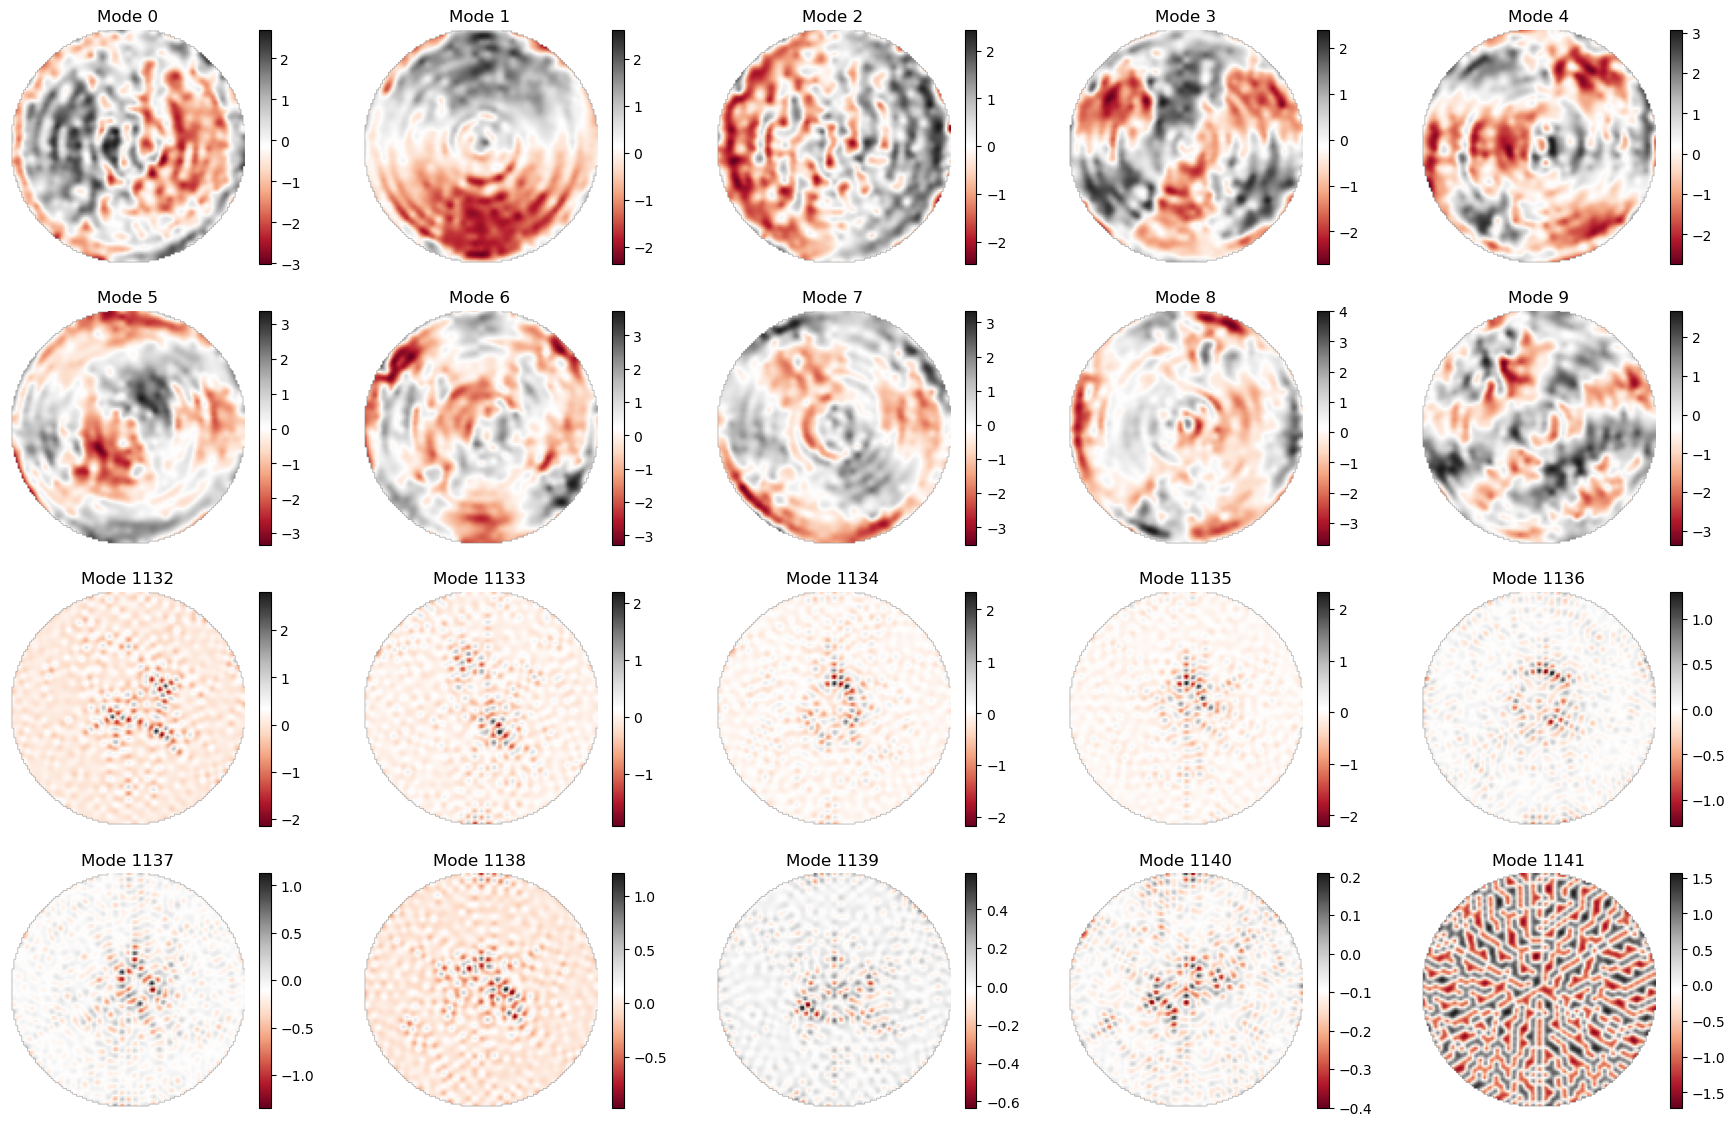

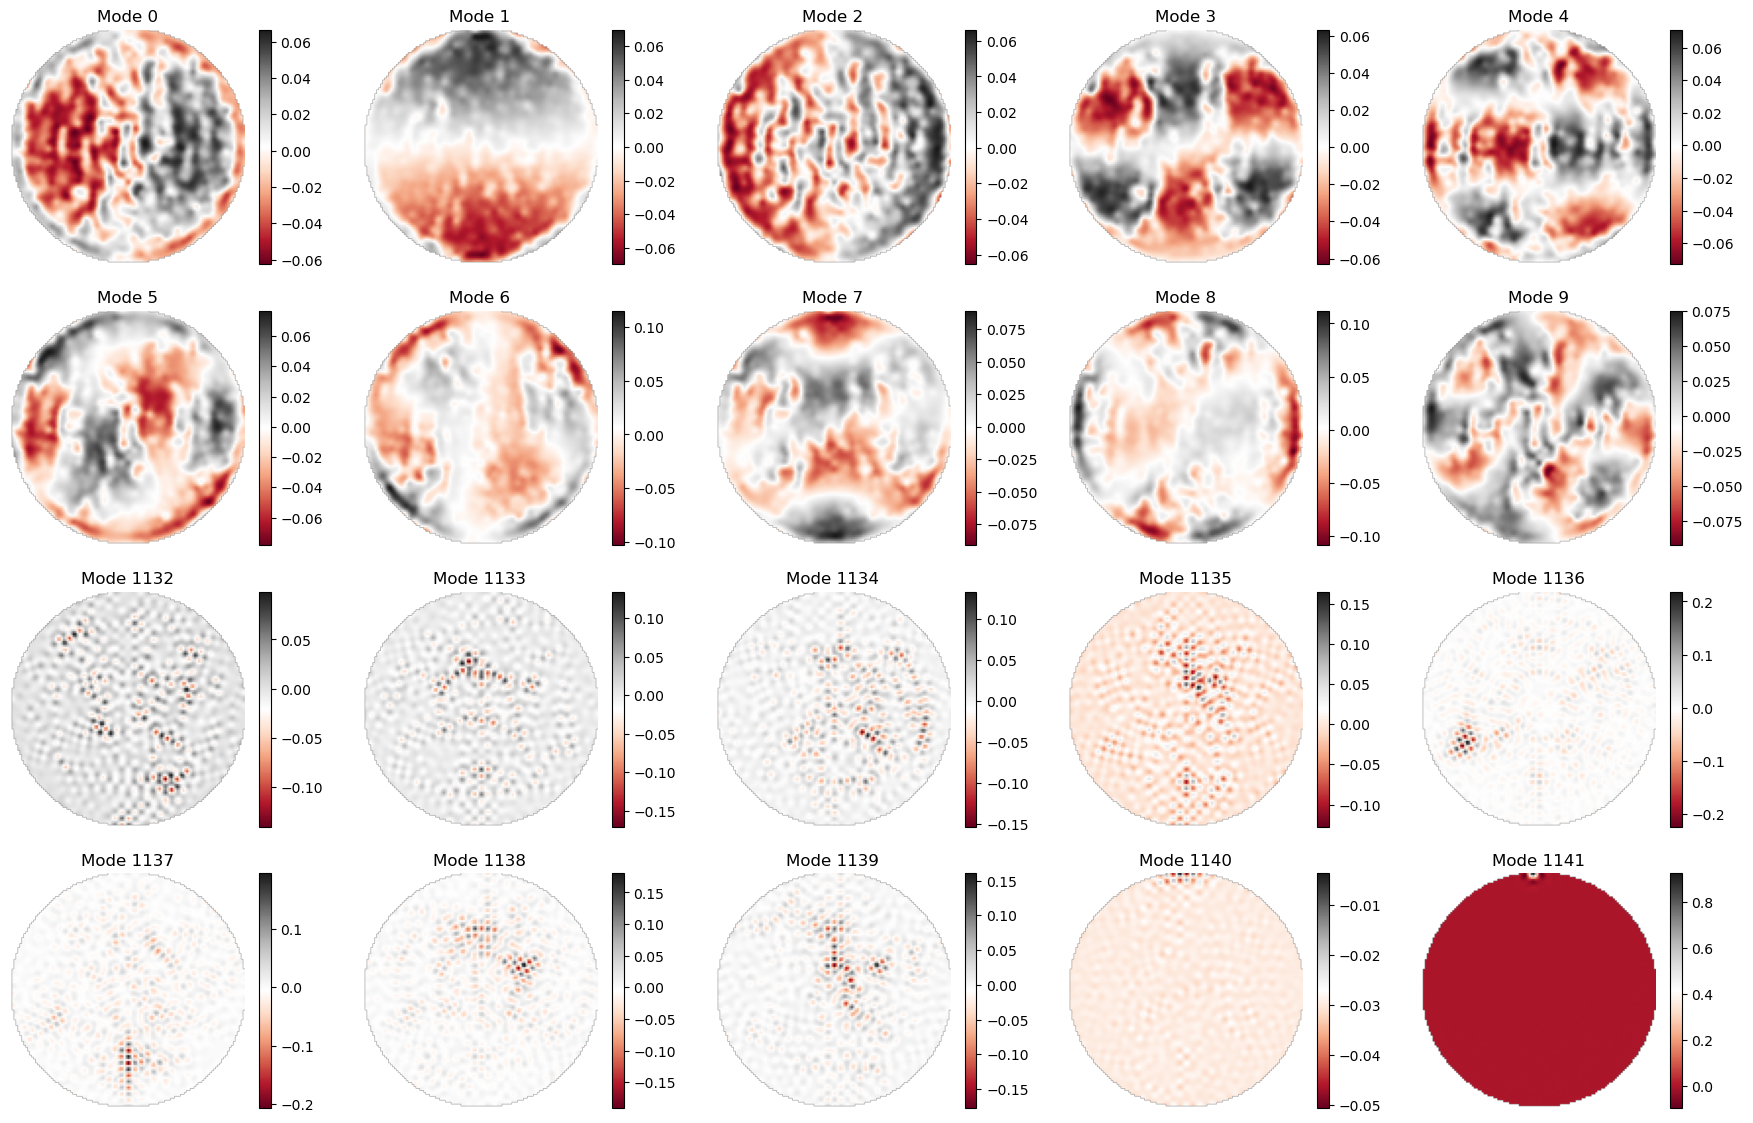

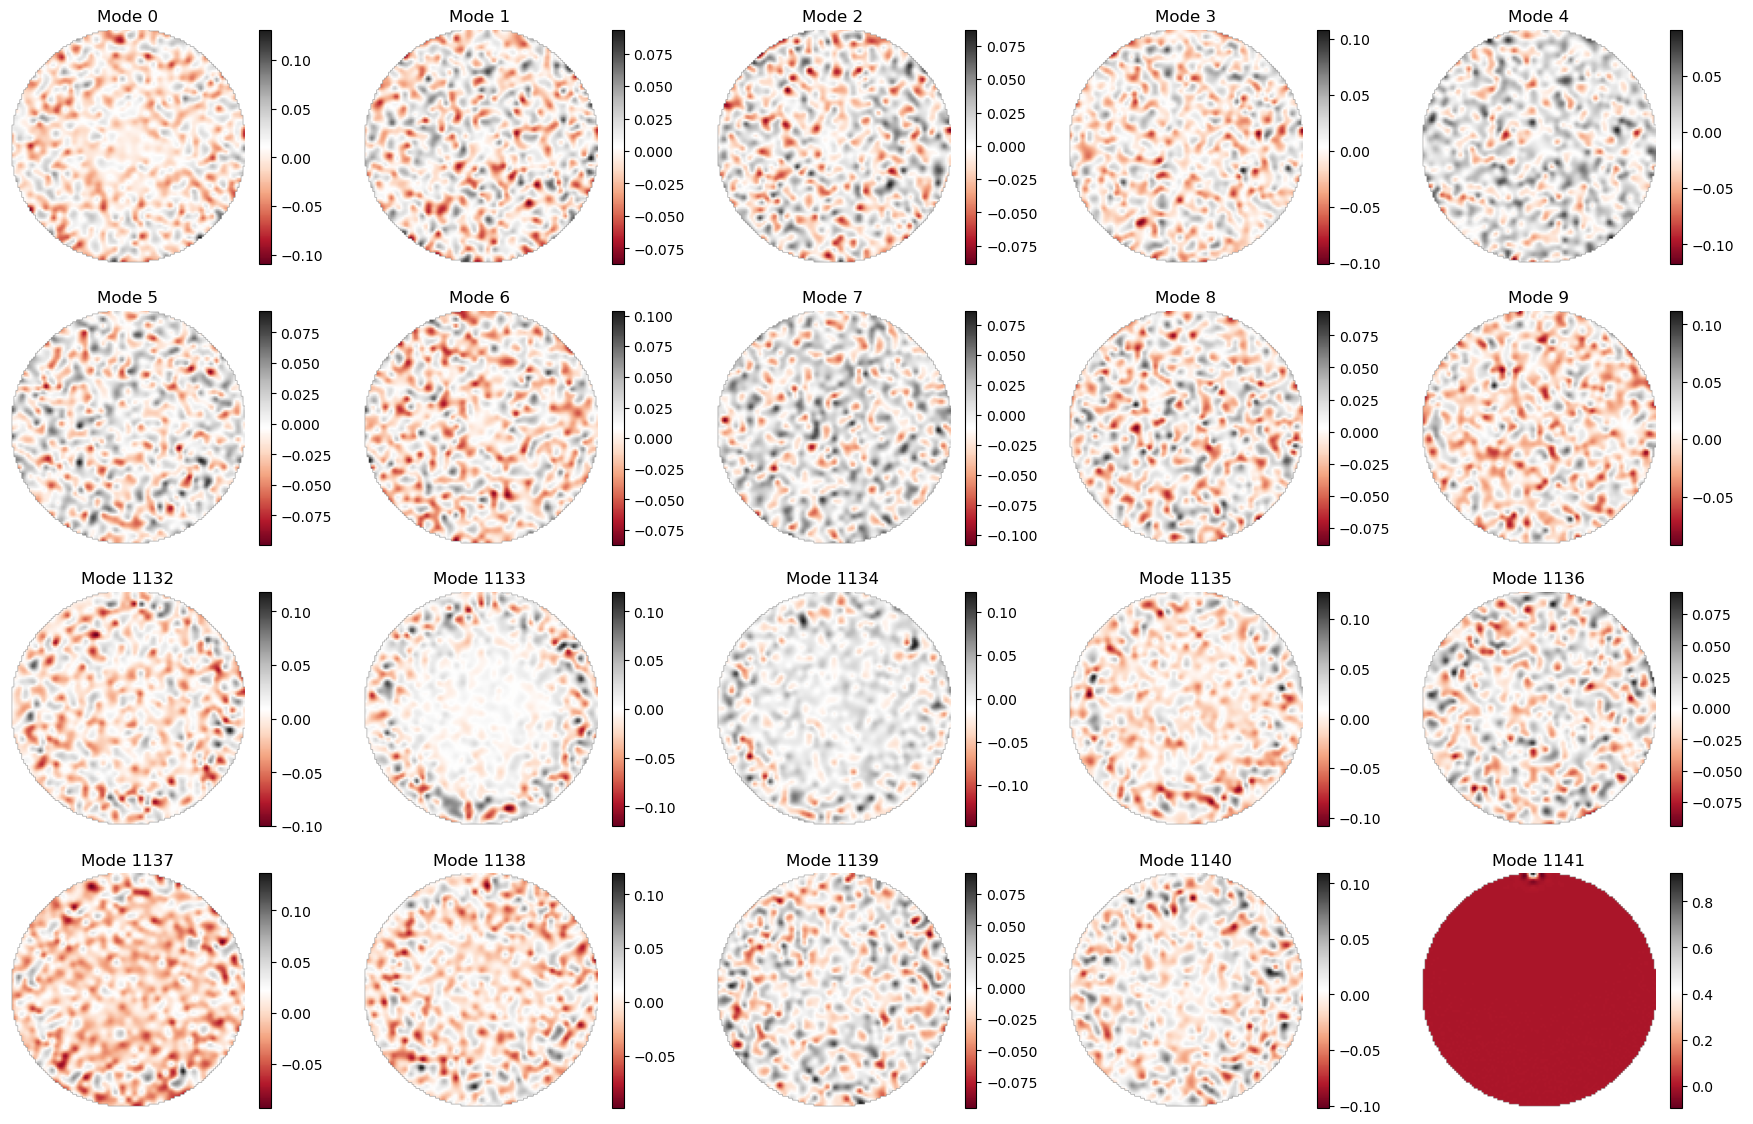

In [ ]:
IntMatH, bf, ref_bright_pix = calibrate_int_mat(dh_phi_in_rad, pupil, hadamat, IF.T, 
                           n_acts=36, oversampling=oversampling, bf_thr=-4, show=True)

IntMatZ, bf, ref_bright_pix = calibrate_int_mat(dh_phi_in_rad, pupil, xp.eye(ssao.dm.Nacts), IF.T, 
                           n_acts=36, oversampling=oversampling, bf_thr=-4, show=True)

# U,D,V = xp.linalg.svd(IntMatZ,full_matrices=False)
# IntMatZ2, bf, ref_bright_pix = calibrate_int_mat(dh_phi_in_rad, pupil, U.T, IF.T, 
#                            n_acts=36, oversampling=oversampling, bf_thr=-4, show=True)

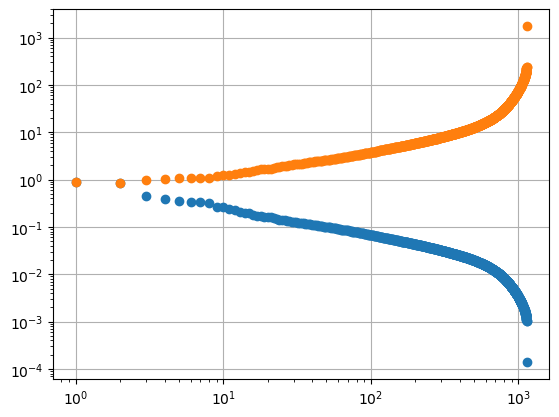

In [ ]:
U,D,V = xp.linalg.svd(IntMatZ,full_matrices=False)

# D[xp.argmax(D)] = 0
maxD = max(D)
Dnorm = D/max(D)

gamma = 1e-3
Dinv = Dnorm/(Dnorm**2 + gamma**2*(Dnorm<=gamma))

plt.figure()
# plt.plot(xp.asnumpy(D/xp.max(D)))
plt.plot(xp.asnumpy(Dnorm),'o')
plt.plot(xp.asnumpy(1/Dinv),'o')
plt.grid()
plt.xscale('log')
plt.yscale('log')

Rec = (V.T * Dinv/maxD) @ U.T #@ xp.linalg.pinv(hadamat)

In [27]:
id = 20
phi = xp.asarray(res_phases[id].data)*m2rad
res_phi_in_rad = phi[~pupil]
dm_phi_in_rad, roi_contrast = define_apodizing_phase(pupil, 
                                  res_phi_in_rad, roi, IF, R, 
                                  oversampling=oversampling, max_its=2000, beta=0.1,
                                  gains=[0.02,0.001], change_gain_its = [100])#, show_step=30)

dm_phi_2d = reshape_on_mask(dm_phi_in_rad,pupil)
res_phi_2d = reshape_on_mask(res_phi_in_rad,pupil)
ref_ef = (1-pupil) * xp.exp(1j*(res_phi_2d+dm_phi_2d),dtype=xp.complex64)
ref_psf = calc_psf(ref_ef, oversampling=oversampling)

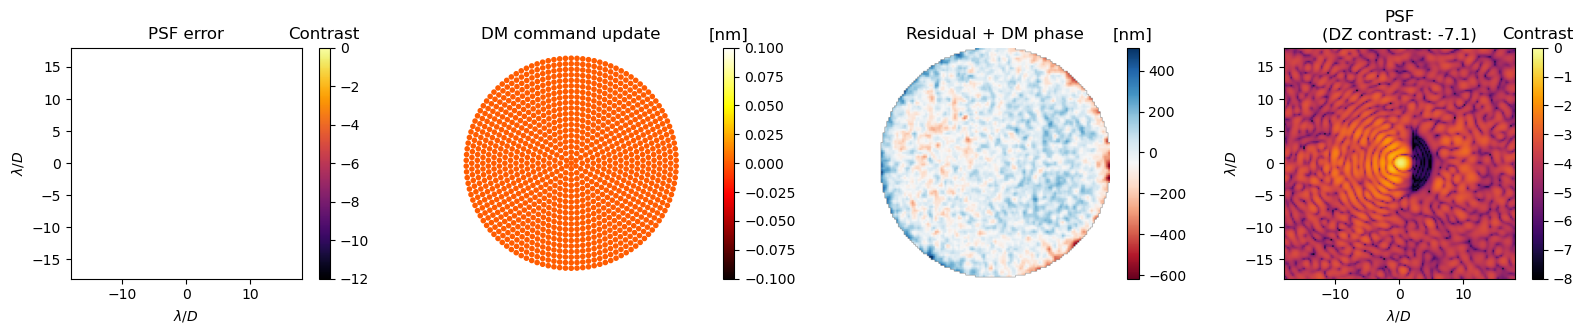

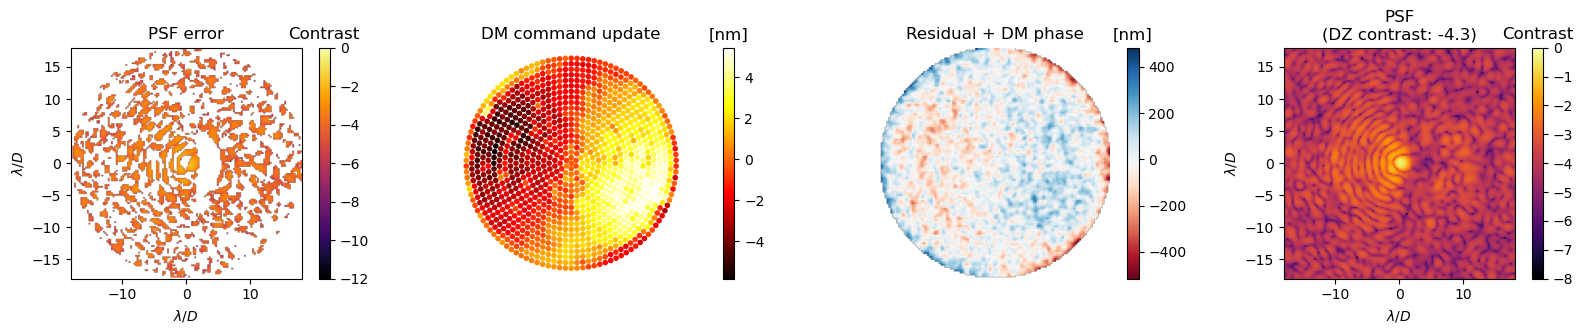

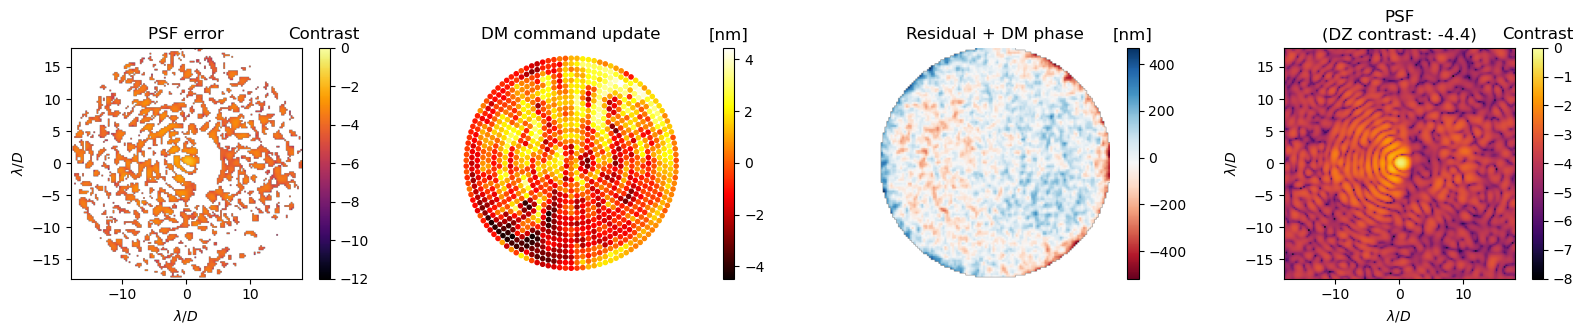

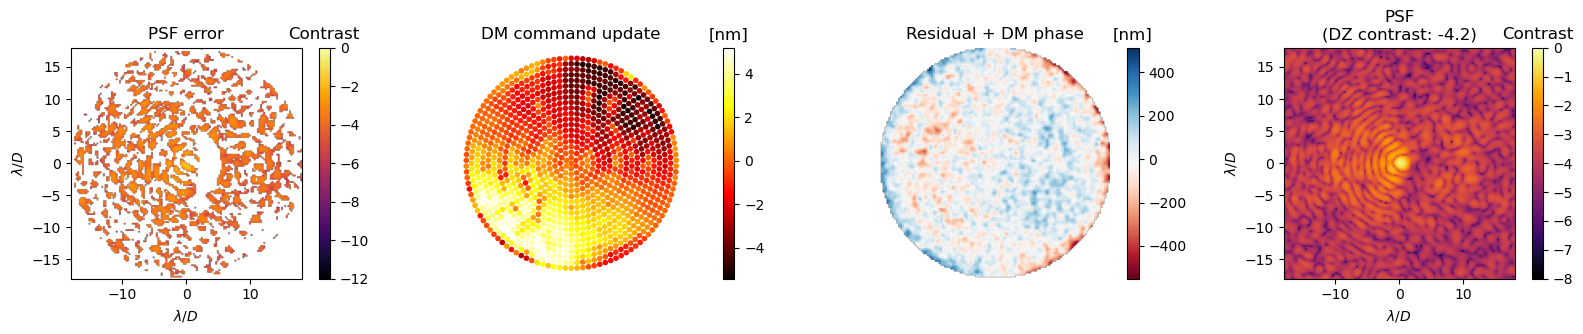

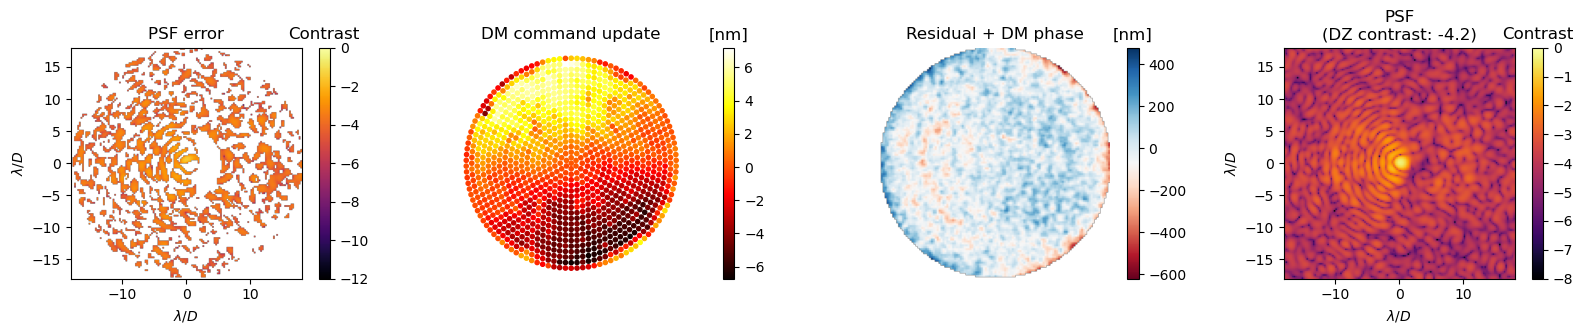

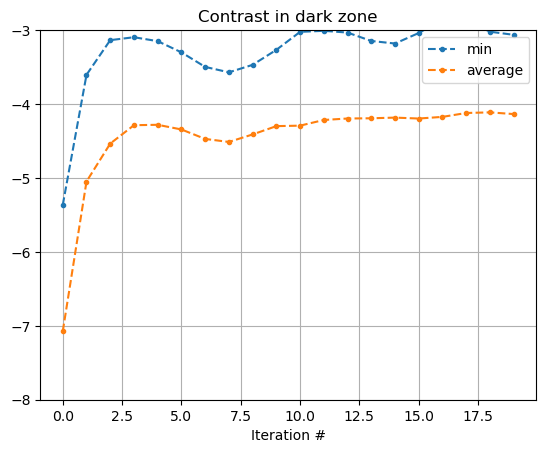

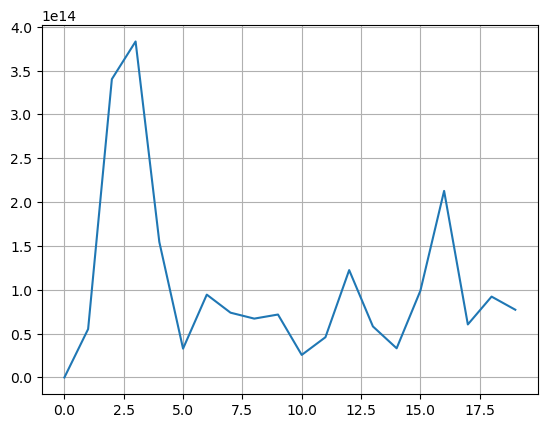

In [28]:
Nits = 20
step = 1
show_step = 4
gain = 0.5

contrasts = xp.zeros([2,Nits])
err_rms = xp.zeros(Nits)

for i in range(Nits):
    phi = xp.asarray(res_phases[id+i*step].data)*m2rad
    res_phi_in_rad = phi[~pupil]
    res_phi_2d = reshape_on_mask(res_phi_in_rad,pupil)
    dm_phi_2d = reshape_on_mask(dm_phi_in_rad,pupil)
    ef = (1-pupil) * xp.exp(1j*(res_phi_2d+dm_phi_2d),dtype=xp.complex64)
    psf = calc_psf(ef, oversampling=oversampling)

    err = psf[bf] - ref_psf[bf]
    err_rms[i] = xp.sum(err**2)

    dm_cmd = Rec.T @ err
    dm_phi = IF.T @ dm_cmd 
    dm_phi_in_rad -= dm_phi * m2rad * gain

    # dm_phi_2d = reshape_on_mask(dm_phi_in_rad,pupil)
    # ef = (1-pupil) * xp.exp(1j*(res_phi_2d+dm_phi_2d),dtype=xp.complex64)
    # psf = calc_psf(ef, oversampling=oversampling)

    contrast = xp.log10(psf/xp.max(dl_psf))
    contrasts[0,i] = xp.max(contrast[roi])
    contrasts[1,i] = xp.mean(contrast[roi])

    if i % show_step == 0:
        plt.figure(figsize=(20,3))
        plt.subplot(1,4,1)
        # plt.imshow(masked_array(xp.asnumpy(res_phi_2d/m2rad*1e+9),mask=xp.asnumpy(pupil)),origin='lower',cmap='RdBu')
        # plt.axis('off')
        # cbar=plt.colorbar()
        # cbar.ax.set_title('[nm]')
        # plt.title('Residual phase')
        show_psf((psf-ref_psf)*bf, norm=xp.max(dl_psf), oversampling=oversampling, title=f'PSF error', vmin=-12)
        plt.subplot(1,4,2)
        ssao.dm.plot_position(dm_cmd*gain)    
        plt.axis('off')
        plt.title('DM command update')
        plt.subplot(1,4,3)
        plt.imshow(masked_array(xp.asnumpy((dm_phi_2d+res_phi_2d)/m2rad*1e+9),mask=xp.asnumpy(pupil)),origin='lower',cmap='RdBu')
        cbar=plt.colorbar()
        cbar.ax.set_title('[nm]')
        plt.title('Residual + DM phase')
        plt.axis('off')
        plt.subplot(1,4,4)
        show_psf(psf, norm=xp.max(dl_psf), oversampling=oversampling, title=f'PSF\n(DZ contrast: {xp.mean(contrast[roi]):1.1f})', vmin=-8)

plt.figure()
plt.plot(xp.asnumpy(contrasts[0]),'--.',label='min')
plt.plot(xp.asnumpy(contrasts[1]),'--.',label='average')
plt.legend()
plt.grid()
plt.ylim([-8,-3])
plt.xlabel('Iteration #')
plt.title('Contrast in dark zone')

plt.figure()
plt.plot(xp.asnumpy(err_rms))
plt.grid()